# **Sentiment Analysis**

**What is sentiment analysis?** 

In simple words, Sentiment analysis is defined as the process of mining of data, view, review or sentence to predict the emotion of the sentence through natural language processing (NLP). The sentiment analysis involve classification of text into three phase “Positive”, “Negative” or“Neutral”. It analyzes the data and labels the ‘better’ and ‘worse’ sentiment as positive and negative respectively.

---

In this analysis different approaches were used:
- a traditional approach using NLTK (Natural Language ToolKit - https://www.nltk.org/)
- some Machine Learning models (KNN, Naive Bayes, Logistic Regression, SVM,) along with pre-trained Deep Learning models (such as HuggingFace's RoBERTa)
- and an extra is the use of some pre-trained pipelines for making sentiment analysis really quick and easy (this will be really useful for the streamlit sentiment analyzer webapp)

## Importing dependencies

In [2]:
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np
import seaborn as sns
import json
import nltk

In [3]:
pd.set_option("max_colwidth", None)
plt.style.use('ggplot')

## Data cleaning

After the data scraping/mining step i ended up with a json file which needs to be converted into a pandas dataframe to simplify the analysis. 

This is the purpose of the **json_2_pandas** function: it takes as input the path where the json file is located, than opens it in 'read' ('r') mode to load the data. After loading the data, I iterate through the object to extract review titles, ratings and contents and adding them to a dictionary.

In [4]:
def json_2_pandas(json_path):
    with open(json_path, 'r') as json_file:
        data = json.load(json_file)
    
    reviews = {"Title": [],
               "Rating": [],
               "Content": []}

    for page in data:
        if len(page) != 0:          # if there are reviews in that page list
            for review in page:
                # append to the lists in the dictionary the desired elements
                reviews['Title'].append(review["title"])
                reviews['Rating'].append(int(review["rating"][:1]))
                reviews['Content'].append(review["body"])
    
    reviews = pd.DataFrame.from_dict(reviews)
    return reviews 

Converting the .json file into a pandas DataFrame.

In [5]:
path = 'G:\Il mio Drive\MAGISTRALE\IT Coding\Project\Sentiment-Analysis-on-Amazon-product-reviews\Data\B075QVMBT9_reviews.json'
df = json_2_pandas(json_path = path)

In [8]:
# to have all the reviews in a .csv file
df.to_csv('../Data/reviews.csv')
# data = pd.read_csv('../Data/reviews.csv')
# data.head()

In [89]:
df.shape

(738, 3)

Defining a review ID column which will be useful for some mergers later on.

In [90]:
df['Id'] = range(1, len(df)+1)

In [91]:
df.head(10)

,Title,Rating,Content,Id
0,Its a beuaty,5,Love its compact shape and sound,1
1,Perfect upgrade for PC Audio,5,"If you ruining cheap PC Speakers those will blow your mind. Clean sound, small frame, good value for money.",2
2,Wonderful monitors,5,"It's been some years since using any monitors as I use DT770 250's for all my audio work and wow, I'm so pleased I added these to my studio.\n\nFirst the sound.\n\nThe sound is quite flat which is good as you can accurately EQ your sound. The bass is ""even"", meaning that it's there but it's not exaggerated. The mids are very well balanced (they sound great) and the high end is also fairly well balanced and you can get some nice air and snap when EQing. For those that have the Bayer Dynamic DT770 250",3
3,Not loud enough,2,These are probably suited for bedroom use and not anything more. The bass kept cutting out with the highs and mids at times also doing the same. Not great at all - I opted for KrK’s instead!,4
4,Faulty,1,Passive speaker won't connect to the main speaker.. Faulty\nVery disappointed,5
5,Brilliant monitor speakers for DJ'ing,5,"Absolutely love these speakers - perfect for DJ'ing at home and loud enough for a little boogie with the kids. Sound quality is great and I'm glad I did my research ahead of time. Build quality is really good, the volume pot is nice and smooth.\n\nThese would be great for home music production or for gaming.\n\nWell worth the investment.",6
6,very good but not as good as the harman kardon soundticks,4,very good but not as good as the harman kardon soundticks\n\nthough these are smaller overall,7
7,Crackling sound when connected to bluetooth,1,"I’d like to preface this review by saying I tried 2 different sets of these speakers (both the bluetooth version), brand new, and both had the EXACT same issue, so must be a model issue rather than a one-off problem.\n\nThe first pair I bought had a constant crackling/buzzing noise coming from the passive speaker when connected to bluetooth. The noise disappeared when disconnected from bluetooth, but appeared instantly when connected. It was audible at low volumes which ruined the listening experi",8
8,These broke after 2 years,1,My speakers broke after a couple of years - useless the amp went inside.,9
9,impressive sound quality!,5,"bought a pair of these for my daughter, so good I kept them and ordered another pair :-)",10


Finally we end up with the pandas DataFrame with 738 reviews, all with title, rating and comment. 

In [112]:
print(df.iloc[0]['Title'])

Its a beuaty


In [92]:
print(df.iloc[7]['Content'])

I’d like to preface this review by saying I tried 2 different sets of these speakers (both the bluetooth version), brand new, and both had the EXACT same issue, so must be a model issue rather than a one-off problem.

The first pair I bought had a constant crackling/buzzing noise coming from the passive speaker when connected to bluetooth. The noise disappeared when disconnected from bluetooth, but appeared instantly when connected. It was audible at low volumes which ruined the listening experi


As we can see from the first review title, there some typing errors which can obviously occur when writing a review. Other than that, it looks like that the punctuation and the backslashes were read properly.

But there could be some missing comments: let's check.

In [93]:
df[df['Content'].str.len() == 0]

,Title,Rating,Content,Id
10,Great deal.,5,,11
51,Impressive,5,,52
76,"Loud, and very clear audio",5,,77
165,Awesome! General balanced sound!,5,,166
289,great job presonus,5,,290
294,Amazing,5,,295
385,The best speakers I have ever owned,5,,386
561,Amazing Sound. Best I have ever heard,5,,562
599,Good quality,3,,600


We have some missing review contents, but thanks to the title and the rating (as we can see) we can draw some sentiment insights either way!

In [94]:
df[df['Rating'] == ""], df[df['Title'] == ""]

(Empty DataFrame
 Columns: [Title, Rating, Content, Id]
 Index: [],
 Empty DataFrame
 Columns: [Title, Rating, Content, Id]
 Index: [])

Looks like we have 0 missing values for all the columns.

## Exploratory Data Analysis

In [131]:
df['Rating'].describe()

count    738.000000
mean       4.479675
std        1.101495
min        1.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: Rating, dtype: float64

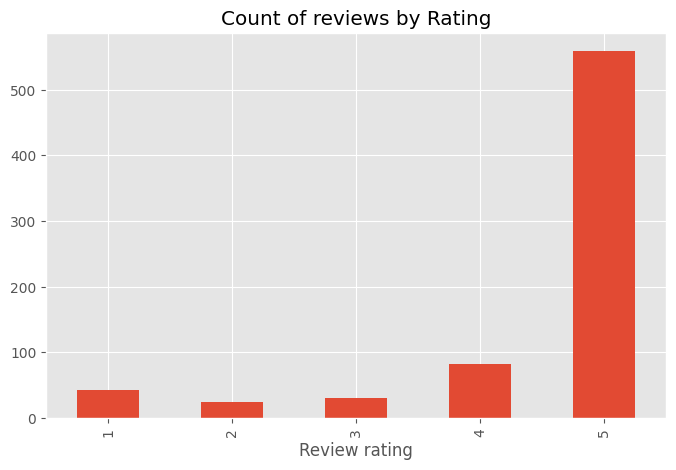

In [96]:
ax = df['Rating'].value_counts().sort_index().plot(kind='bar', title='Count of reviews by Rating', figsize=(8,5))
ax.set_xlabel('Review rating')
plt.show()

Very biased towards positive reviews. That's good to know.

#### NLTK

In [97]:
import nltk
# nltk.download('vader_lexicon')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('maxent_ne_chunker')
# nltk.download('words')

In [98]:
example = df['Content'][4]
print(example)

Passive speaker won't connect to the main speaker.. Faulty
Very disappointed


In [99]:
tokens = nltk.word_tokenize(example)
tokens

['Passive',
 'speaker',
 'wo',
 "n't",
 'connect',
 'to',
 'the',
 'main',
 'speaker',
 '..',
 'Faulty',
 'Very',
 'disappointed']

Tokenized result: basically beginning to convert a sentence into a format which is understable by the computer. As we can see nltk is smart because it detects the won't word and splits it into 'wo' and "n't".

Now find the part of speech for each of these words:

In [100]:
tag = nltk.pos_tag(tokens)
tag

[('Passive', 'JJ'),
 ('speaker', 'NN'),
 ('wo', 'MD'),
 ("n't", 'RB'),
 ('connect', 'VB'),
 ('to', 'TO'),
 ('the', 'DT'),
 ('main', 'JJ'),
 ('speaker', 'NN'),
 ('..', 'NNP'),
 ('Faulty', 'NNP'),
 ('Very', 'RB'),
 ('disappointed', 'VBD')]

Whta is the meaning of these tags? Add link

Putting now these tags - part of speech into entities.

In [101]:
entities = nltk.chunk.ne_chunk(tag)
entities.pprint()       # pretty print nltk function

(S
  (GPE Passive/JJ)
  speaker/NN
  wo/MD
  n't/RB
  connect/VB
  to/TO
  the/DT
  main/JJ
  speaker/NN
  ../NNP
  Faulty/NNP
  Very/RB
  disappointed/VBD)


----

### VADER


In [102]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [103]:
sia

In [104]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

Compound is an aggregation of the 3, goes from -1 to 1.

In [105]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [106]:
print(example)
print(sia.polarity_scores(example))

Passive speaker won't connect to the main speaker.. Faulty
Very disappointed
{'neg': 0.367, 'neu': 0.516, 'pos': 0.116, 'compound': -0.5984}


In [107]:
# run on entire dataset
results = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    text = row['Content']
    Id = row['Id']
    results[Id] = sia.polarity_scores(text)

  0%|          | 0/738 [00:00<?, ?it/s]

In [111]:
vaders = pd.DataFrame(results).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')
vaders.head()

,Id,neg,neu,pos,compound,Title,Rating,Content
0,1,0.000,0.543,0.457,0.6369,Its a beuaty,5,Love its compact shape and sound
1,2,0.080,0.600,0.320,0.7184,Perfect upgrade for PC Audio,5,"If you ruining cheap PC Speakers those will blow your mind. Clean sound, small frame, good value for money."
2,3,0.000,0.804,0.196,0.9594,Wonderful monitors,5,"It's been some years since using any monitors as I use DT770 250's for all my audio work and wow, I'm so pleased I added these to my studio.\n\nFirst the sound.\n\nThe sound is quite flat which is good as you can accurately EQ your sound. The bass is ""even"", meaning that it's there but it's not exaggerated. The mids are very well balanced (they sound great) and the high end is also fairly well balanced and you can get some nice air and snap when EQing. For those that have the Bayer Dynamic DT770 250"
3,4,0.134,0.866,0.000,-0.6232,Not loud enough,2,These are probably suited for bedroom use and not anything more. The bass kept cutting out with the highs and mids at times also doing the same. Not great at all - I opted for KrK’s instead!
4,5,0.367,0.516,0.116,-0.5984,Faulty,1,Passive speaker won't connect to the main speaker.. Faulty\nVery disappointed


Is this in line with what we expect? If the rating is 5-4, is the rating positive?

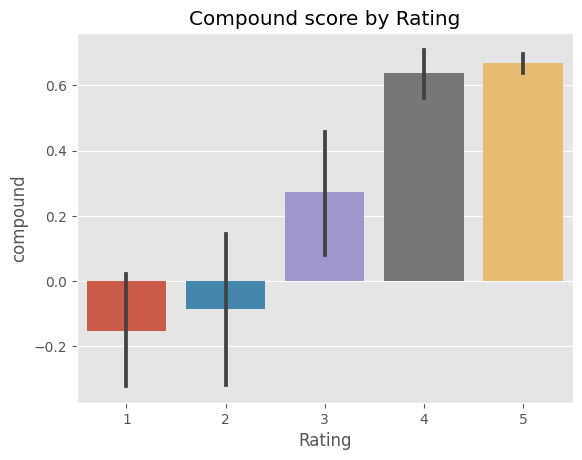

In [ ]:
ax = sns.barplot(data=vaders, x='Rating', y='compound')
ax.set_title('Compound score by Rating')
plt.show()

It is what we would expect!

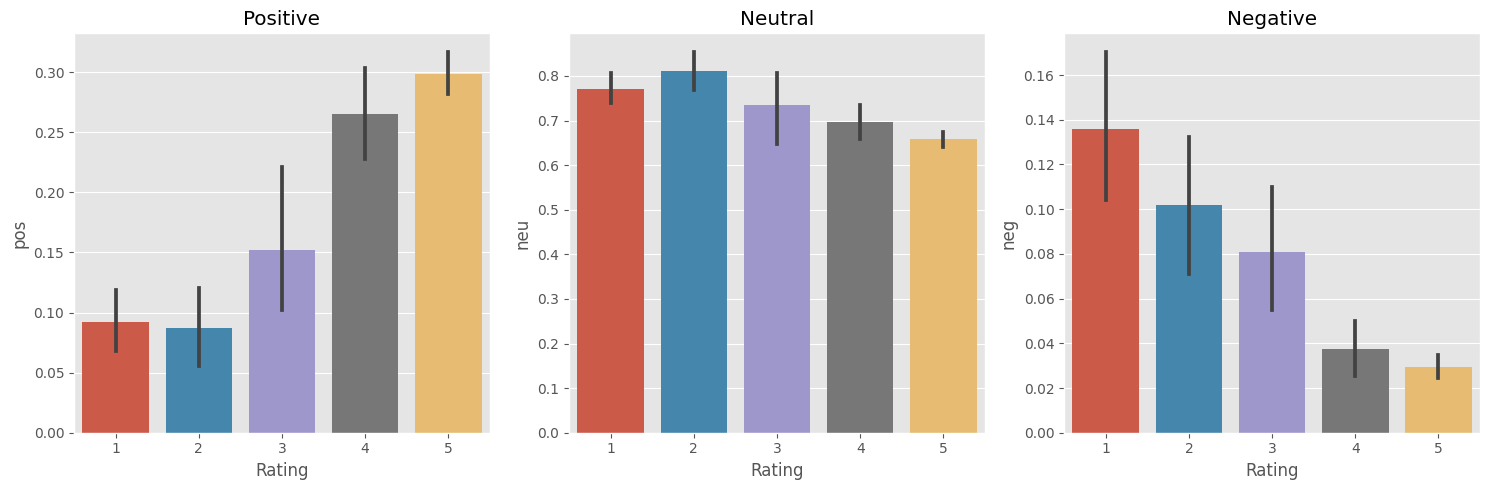

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
sns.barplot(data = vaders, x='Rating', y='pos', ax = axs[0])
sns.barplot(data = vaders, x='Rating', y='neu', ax = axs[1])
sns.barplot(data = vaders, x='Rating', y='neg', ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

### RoBERTa

### The Transformers Pipeline

In [ ]:
# from transformers import pipeline

# sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


RuntimeError: At least one of TensorFlow 2.0 or PyTorch should be installed. To install TensorFlow 2.0, read the instructions at https://www.tensorflow.org/install/ To install PyTorch, read the instructions at https://pytorch.org/.

In [ ]:
sent_pipeline = ('phrase')

NameError: name 'sent_pipeline' is not defined